In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M')
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import kmeans1d
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

In [2]:
df = pd.read_csv('./inv2_emi_data_t345678.csv',
                encoding="utf-8-sig",
                header=0,
                infer_datetime_format=True,
                parse_dates={'datetime':[5]},
                index_col=['datetime']
                )

In [3]:
df['time'] = df.index
df.loc[:,'year'] = pd.Series(df.index.year, df.index)
df.loc[:,'month'] = pd.Series(df.index.month, df.index)
df.loc[:,'day'] = pd.Series(df.index.day, df.index)
df.loc[:,'hour'] = pd.Series(df.index.hour, df.index)
df.loc[:,'dayofweek'] = pd.Series(df.index.dayofweek, df.index)
df.loc[:,'dayname'] = pd.Series(df.index.day_name(), df.index)
df.loc[:,'hourofweek'] = pd.Series((df.hour+24*df.dayofweek), df.index)
df.loc[:,'hourofmonth'] = pd.Series((df.hour+24*(df.day-1)), df.index)
df.loc[:,'Tcell']=pd.Series((df['Ambient temperature(℃)']+df['Irradiance(W/㎡)']/800*(25-20)), df.index)
df.loc[:,'Pm']=pd.Series((2.172*1.303*220*2*590*df['Irradiance(W/㎡)']/1000*(1+0.0045*(df['Tcell']-25))*20.5/100), df.index)
df.loc[:,'Hieu suat']=pd.Series((df['Total input power(kW)']*1000/df['Pm']*100), df.index)
df.loc[:,'date'] = pd.Series(df.index.date, df.index)
df=df[df['Ambient temperature(℃)']>6]
df=df[df['Irradiance(W/㎡)']>300]
df=df[df['Total input power(kW)']>76]
df=df[df['Hieu suat']<100]
df.head()

,Unnamed: 0.1,Unnamed: 0,Site Name,Management Domain,ManageObject_x,Ambient temperature(℃),PV Temperature(℃),Wind speed(m/s),Wind direction(°),Daily irradiation(MJ/㎡),...,day,hour,dayofweek,dayname,hourofweek,hourofmonth,Tcell,Pm,Hieu suat,date
datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-04 10:20:00,104,104,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,29.4,41.2,1.4,NaN,4.039,...,4,10,4,Friday,106,82,33.389375,99765.707730,89.783355,2022-03-04
2022-03-04 10:25:00,105,105,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,29.3,42.0,2.4,NaN,4.252,...,4,10,4,Friday,106,82,34.078750,119863.526665,76.805683,2022-03-04
2022-03-04 10:30:00,106,106,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,29.3,42.9,4.5,NaN,4.197,...,4,10,4,Friday,106,82,34.449375,129366.728410,72.081130,2022-03-04
2022-03-04 10:35:00,107,107,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,29.7,44.7,0.8,NaN,4.444,...,4,10,4,Friday,106,82,34.868125,130072.464747,71.713871,2022-03-04
2022-03-04 10:40:00,108,108,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,29.7,45.6,2.0,NaN,4.692,...,4,10,4,Friday,106,82,34.773750,127645.289181,72.532250,2022-03-04


In [4]:
ngay=[1]
dem=1
i=1
while i!=len(df['time']):
    if (df['day'][i]!=df['day'][i-1]):
        dem=dem+1
    ngay.append(dem)
    i=i+1

In [5]:
def find_most_frequent(arr):
    counts = {}
    max_count = 0
    max_item = None
    for item in arr:
        if item not in counts:
            counts[item] = 1
        else:
            counts[item] += 1
        if counts[item] > max_count:
            max_count = counts[item]
            max_item = item
    return max_item

In [6]:
hieusuattb=[]
i=1
while i<=dem:
    hieusuat=df['Hieu suat'].tolist()
    df1=pd.DataFrame({'Hieu suat':hieusuat})
    df1['ngay']=ngay
    df1=df1[df1['ngay']==i]
    arr=df1['Hieu suat'].tolist()
    k=len(arr)//2
    if k==0:
        k=1
    kclusters, centroids = kmeans1d.cluster(arr,k)
    a=find_most_frequent(kclusters)
    hieusuattb.append(centroids[a])
    i=i+1
fig = px.line(df, x=list(range(0,len(hieusuattb))), y=hieusuattb)
fig.show()



In [7]:
df_binary=pd.DataFrame({'Hieu suat':hieusuattb})
df_binary=df_binary[df_binary['Hieu suat']>60]
df_binary['stt']=df_binary.index
print(df_binary)


     Hieu suat  stt
0    71.850936    0
1    75.102663    1
2    79.706186    2
3    65.821391    3
4    66.778608    4
..         ...  ...
138  64.140045  138
139  65.065892  139
140  64.348042  140
141  67.451237  141
142  68.636790  142

[143 rows x 2 columns]


0.2597678784028129


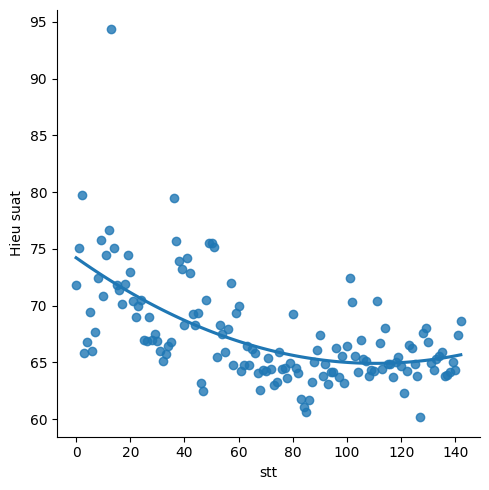

In [8]:
sns.lmplot(x ="stt", y ="Hieu suat", data = df_binary, order = 2, ci = None)
# Eliminating NaN or missing input numbers 
df_binary.fillna(method ='ffill', inplace = True)
X = np.array(df_binary['stt']).reshape(-1, 1) 
y = np.array(df_binary['Hieu suat']).reshape(-1, 1) 
  
# Separating the data into independent and dependent variables 
# Converting each dataframe into a numpy array  
# since each dataframe contains only one column 
df_binary.dropna(inplace = True) 
  
# Dropping any rows with Nan values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
  
# Splitting the data into training and testing data 
regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

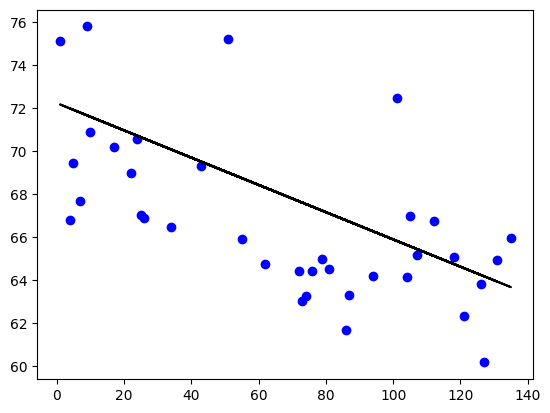

In [9]:
y_pred = regr.predict(X_test) 
plt.scatter(X_test, y_test, color ='b') 
plt.plot(X_test, y_pred, color ='k') 
  
plt.show() 

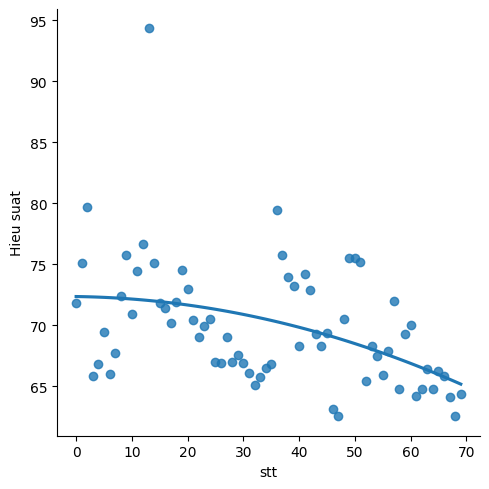

In [10]:
df_binary1 = df_binary[:][:70]
  
# Selecting the 1st 500 rows of the data 
sns.lmplot(x ="stt", y ="Hieu suat", data = df_binary1, 
                               order = 2, ci = None)

In [11]:
df_binary1.fillna(method ='ffill', inplace = True) 
  
X = np.array(df_binary1['stt']).reshape(-1, 1) 
y = np.array(df_binary1['Hieu suat']).reshape(-1, 1) 
  
df_binary1.dropna(inplace = True) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
  
regr = LinearRegression() 
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

0.04246002049696307


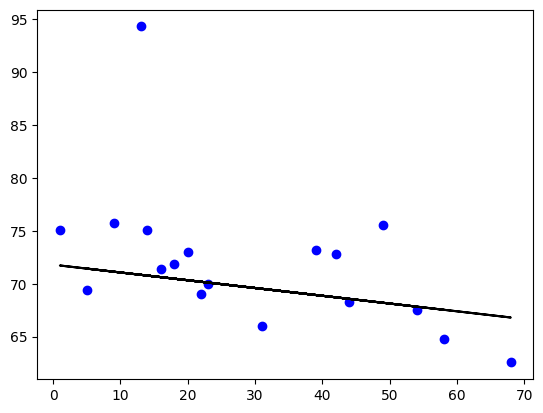

In [12]:
y_pred = regr.predict(X_test) 
plt.scatter(X_test, y_test, color ='b') 
plt.plot(X_test, y_pred, color ='k') 
  
plt.show() 

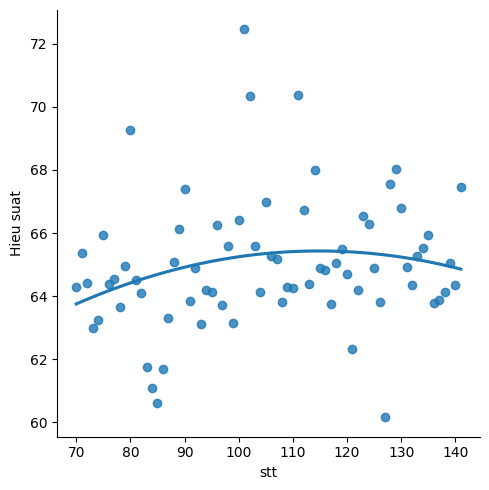

In [13]:
df_binary2 = df_binary[:][70:142]
  
# Selecting the 1st 500 rows of the data 
sns.lmplot(x ="stt", y ="Hieu suat", data = df_binary2, 
                               order = 2, ci = None)

In [14]:
df_binary2.fillna(method ='ffill', inplace = True) 
  
X = np.array(df_binary2['stt']).reshape(-1, 1) 
y = np.array(df_binary2['Hieu suat']).reshape(-1, 1) 
  
df_binary2.dropna(inplace = True) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
  
regr = LinearRegression() 
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

0.01944985513657349


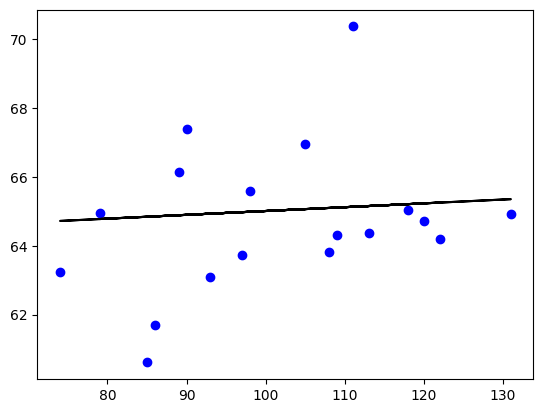

In [15]:
y_pred = regr.predict(X_test) 
plt.scatter(X_test, y_test, color ='b') 
plt.plot(X_test, y_pred, color ='k') 
  
plt.show() 